# QCoDeS Example with with Keithley 2600

In [1]:
import qcodes as qc

from qcodes.instrument_drivers.tektronix.Keithley_2600_channels import Keithley_2600
from qcodes.dataset.plotting import plot_dataset
from qcodes.dataset.sqlite.database import initialise_database
from qcodes.dataset.experiment_container import new_experiment
from qcodes.utils.dataset.doNd import do0d

In [2]:
# Create a station to hold all the instruments

station = qc.Station()

# instantiate the Keithley and add it to the station

keith = Keithley_2600('keithley', 'USB0::0x05E6::0x2614::4305420::INSTR')
station.add_component(keith)

Connected to: Keithley Instruments Inc. 2614B (serial:4305420, firmware:3.2.2) in 0.77s


'keithley'

The Keithley 2600 has two channels, here called `smua` and `smub` in agreement with the instrument manual.

The two channels are basically two separate instruments with different integration times (`nplc`), operation modes (`mode`) etc.

In [3]:
# Get an overview of the settings
#
# You will notice that the two channels have identical parameters but
# potentially different values for them
#
keith.print_readable_snapshot()

keithley:
	parameter      value
--------------------------------------------------------------------------------
IDN             :	{'vendor': 'Keithley Instruments Inc.', 'model': '2614B', '...
display_settext :	None 
timeout         :	5 (s)
keithley_smua:
	parameter                  value
--------------------------------------------------------------------------------
curr                        :	8.7023e-07 (A)
fastsweep                   :	Not available 
limiti                      :	0.1 (A)
limitv                      :	20 (V)
linefreq                    :	50 (Hz)
measure_autorange_i_enabled :	False 
measure_autorange_v_enabled :	True 
measurerange_i              :	0.1 (A)
measurerange_v              :	200 (V)
mode                        :	current 
nplc                        :	0.05 
output                      :	True 
res                         :	2.2985e+07 (Ohm)
source_autorange_i_enabled  :	True 
source_autorange_v_enabled  :	False 
sourcerange_i               :	0.1 (A)
sourcer

## Basic operation

Each channel operates in either `voltage` or `current` mode. The mode controls the _source_ behaviour of the instrument, i.e. `voltage` mode corresponds to an amp-meter (voltage source, current meter) and vice versa.

In [4]:
# Let's set up a single-shot current measurement
# on channel a

keith.smua.mode('voltage')
keith.smua.nplc(0.05)  # 0.05 Power Line Cycles per measurement. At 50 Hz, this corresponds to 1 ms
keith.smua.sourcerange_v(20) 
keith.smua.measurerange_i(0.1)
#
keith.smua.volt(1)  # set the source to output 1 V
keith.smua.output('on')  # turn output on
curr = keith.smua.curr()
keith.smua.output('off')

print('Measured one current value: {} A'.format(curr))

Measured one current value: -3.40939e-06 A


## Fast IV or VI curves

Onboard the Keithley 2600 sits a small computer that can interpret `Lua` scripts. This can be used to make fast IV- or VI-curves and is supported by the QCoDeS driver. To make IV- or VI-curves the driver has the ArrayParameter fastsweep, which have 3 modes: 'IV','VI' and 'VIfourprobe'.  The Modes 'IV' and 'VI'are two probe measurements, while the mode 'VIfourprobe' makes a four probe measuremnt.

Let's make a fast IV curve by sweeping the voltage from 1 V to 2 V in 500 steps
(when making this notebook, nothing was connected to the instrument, so we just measure noise)

First we need to prepare the sweep by spesifyring the start, stop, number of points and the mode  

In [5]:
keith.smua.fastsweep.prepareSweep(1, 2, 500, mode='IV')

When the sweep parameters are set, we can use a "do0d" to preform the sweep 

Starting experimental run with id: 154. 


(results #154@C:\Users\Farzad\experiments.db
 -------------------------------------------
 keithley_smua_Voltage - array
 keithley_smua_iv_sweep - array,
 [<AxesSubplot:title={'center':'Run #154, Experiment tutorial_exp (no sample)'}, xlabel='keithley_smua_Voltage (V)', ylabel='current (μA)'>],
 [None])

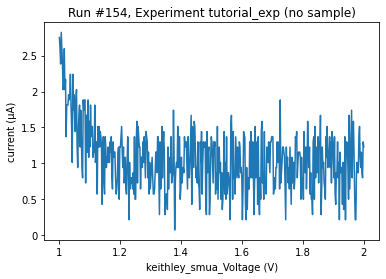

In [6]:
do0d(keith.smua.fastsweep, do_plot = True)

We can likewise do a VI two- or four-probe measurement 

Starting experimental run with id: 155. 


(results #155@C:\Users\Farzad\experiments.db
 -------------------------------------------
 keithley_smua_Current - array
 keithley_smua_vi_sweep - array,
 [<AxesSubplot:title={'center':'Run #155, Experiment tutorial_exp (no sample)'}, xlabel='keithley_smua_Current (mA)', ylabel='voltage (V)'>],
 [None])

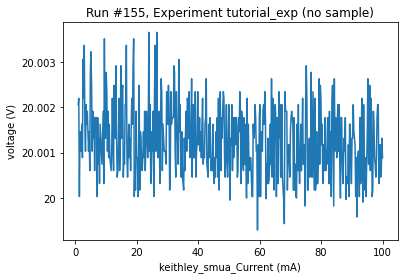

In [7]:
keith.smua.fastsweep.prepareSweep(0.001, 0.1, 500, mode='VI')
do0d(keith.smua.fastsweep, do_plot = True)

Starting experimental run with id: 156. 


(results #156@C:\Users\Farzad\experiments.db
 -------------------------------------------
 keithley_smua_Current - array
 keithley_smua_vi_sweep_four_probe - array,
 [<AxesSubplot:title={'center':'Run #156, Experiment tutorial_exp (no sample)'}, xlabel='keithley_smua_Current (mA)', ylabel='voltage (V)'>],
 [None])

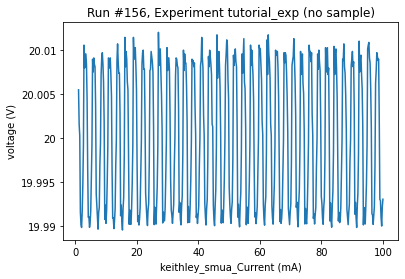

In [8]:
keith.smua.fastsweep.prepareSweep(0.001, 0.1, 500, mode='VIfourprobe')
do0d(keith.smua.fastsweep, do_plot = True)


In [ ]:
do0d(keith.smua.fastsweep, do_plot = True)

In [ ]:
# Finally, tear down the instrument
keith.close()

## Time Trace

We can measure current or voltage as a function of time, as well. Let us consider the case in which we would like to have the time trace of current. We, then, first set our trace mode accordingly

In [9]:
keith.smua.timetrace_mode('current')

The latter should not be confused with the channel mode. Next, we register our parameter

In [10]:
timemeas = qc.Measurement()
timemeas.register_parameter(keith.smua.timetrace)

The total time interval is returned by `time_axis` method in accordance with the integration time `dt` and the total number of points `npts` with default values of 1 ms and 500, respectively. Specifically, the time trace will be obtained for an interval of `[0, dt*npts]`. Thus, for the default values, we shall have a time trace of current for `500 ms` calculated at 500 steps.

In [11]:
keith.smua.timetrace_dt()

0.001

In [12]:
keith.smua.timetrace_npts()

500

Starting experimental run with id: 157. 


([<AxesSubplot:title={'center':'Run #157, Experiment tutorial_exp (no sample)'}, xlabel='Time (ms)', ylabel='Current (μA)'>],
 [None])

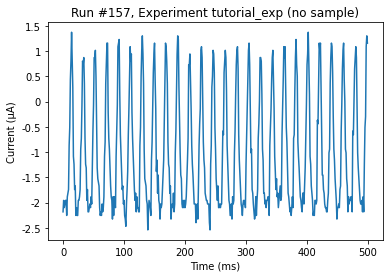

In [13]:
initialise_database()
new_experiment(name='tutorial_exp', sample_name="no sample")

with timemeas.run() as datasaver:
    
    somenumbers = keith.smua.timetrace.get()
    datasaver.add_result((keith.smua.timetrace, somenumbers), 
                         (keith.smua.time_axis, keith.smua.time_axis.get()))
    
data = datasaver.dataset
plot_dataset(data)

Let us get another trace for 2ms integration time with 600 steps

In [14]:
keith.smua.timetrace_dt(0.002)

In [15]:
keith.smua.timetrace_npts(600)

Starting experimental run with id: 158. 


([<AxesSubplot:title={'center':'Run #158, Experiment tutorial_exp (no sample)'}, xlabel='Time (s)', ylabel='Current (μA)'>],
 [None])

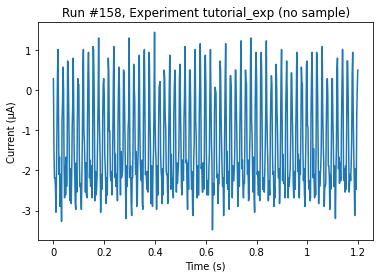

In [16]:
with timemeas.run() as datasaver:
    
    somenumbers = keith.smua.timetrace.get()
    datasaver.add_result((keith.smua.timetrace, somenumbers), 
                         (keith.smua.time_axis, keith.smua.time_axis.get()))
    
data = datasaver.dataset
plot_dataset(data)

Similarly, we can get the time trace for voltage via changing the mode

In [18]:
keith.smua.timetrace_mode('voltage')

In this case, one should re-register the time trace parameter to have the correct units and labels.

## Recalibration

Sometimes it happens that Keithley SMU measures a different value from what was assigned as the setpoint; e.g. when setting the voltage to ``-2 mV``, the SMU would measure an output of ``-1.85 mV``. This likely calls for recalibration of the Keithley SMU against e.g. a calibrated DMM. After this recalibration the measured value matches the setpoint.

Below is a description of using a calibration routine that is based off the information from the instrument manual about performing the calibration.

To run this routine, connect the Keithley SMU HI voltage output to the DMM voltage HI input, and the SMU LO output to the DMM voltage LO input (note that this is a different setup as indicated in the Keithley manual).

In [ ]:
#%% The calibration functions
from qcodes.calibrations.keithley import (
    calibrate_keithley_smu_v,
    calibrate_keithley_smu_v_single,
)

#%% Load DMM instrument, the SMU is assumed to be imported and connected to
from qcodes.instrument_drivers.Keysight.Keysight_34470A_submodules import (
    Keysight_34470A,
)
dmm = Keysight_34470A("dmm", "TCPIP0::10.164.54.211::inst0::INSTR")

# %% Calibrate both channels
calibrate_keithley_smu_v(smu, dmm)
smu.smua.volt(0)
smu.smub.volt(0)

#%% Calibrate single channel in specific range
setup_dmm(dmm)
dmm.range(1.0)
calibrate_keithley_smu_v_single(smu, "smua", dmm.volt, "200e-3")
smu.smua.volt(0)

#%% Check calibration by measuring voltage with DMM while sweeping with SMU
smun = smu.smua

smun.sourcerange_v(200e-3)
smun.measurerange_v(200e-3)
smun.volt(0)
smun.output("on")

dmm.aperture_time(0.1)
dmm.range(1)
dmm.autozero("OFF")
dmm.autorange("OFF")

load_or_create_experiment(
    "MeasurementSetupDebug", "no_sample", load_last_duplicate=True
)

do1d(
    smun.volt,
    -0.1e-3,
    0.1e-3,
    101,
    0.3,
    dmm.volt,
    smun.curr,
    measurement_name="smu calibration check",
)

smun.volt(0)
smun.output("off")

#%% Save calibrations
save_calibration(smu)

